In [ ]:
!pip install gdcm
!pip install pylibjpeg-libjpeg
!pip install pylibjpeg

     |████████████████████████████████| 2.7 MB 23.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.2 MB 25.0 MB/s eta 0:00:01
     |████████████████████████████████| 970 kB 30.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.6 MB 28.3 MB/s eta 0:00:01


In [ ]:
from fastai.vision.all import *
from fastai.medical.imaging import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = Path('./New Data/train-Data/train/')

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
    get_items=get_dicom_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(512)
    )

In [ ]:
dls = dblock.dataloaders(path, bs = 16, num_workers=0)

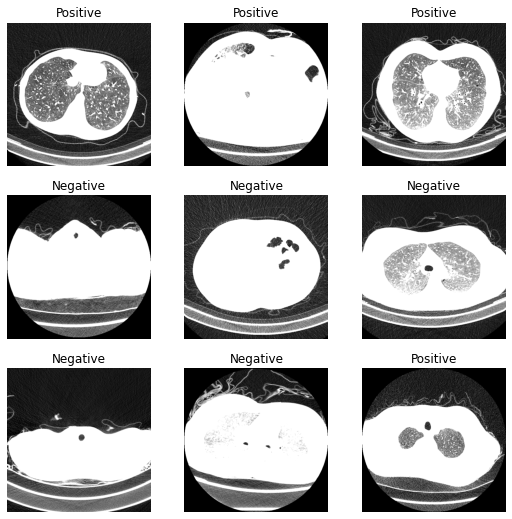

In [ ]:
dls.train.show_batch(max_n=9, nrows=3)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, 
                    Precision(), Recall(), F1Score()]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

SuggestedLRs(valley=0.001737800776027143)

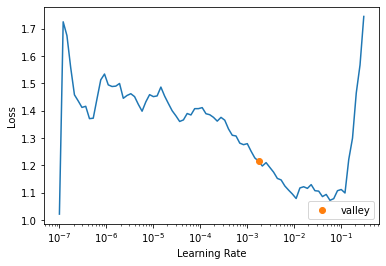

In [ ]:
learn.lr_find()

In [ ]:
len(dls.train_ds), len(dls.valid_ds)

(11378, 2844)

In [ ]:
learn.fine_tune(epochs=2,
          base_lr=0.001737800776027143,
          cbs=[SaveModelCallback(monitor='f1_score')])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.233903,0.095487,0.964135,0.963220,0.965901,0.964559,07:59


Better model found at epoch 0 with f1_score value: 0.9645587213342598.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.070046,0.003789,0.998945,0.997917,1.000000,0.998957,03:47
1,0.010540,0.001031,0.999648,0.999305,1.000000,0.999652,03:48


Better model found at epoch 0 with f1_score value: 0.9989572471324296.
Better model found at epoch 1 with f1_score value: 0.9996521739130434.


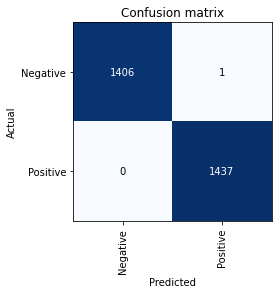

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
learn.fit_one_cycle(n_epoch=2, lr_max=0.001737800776027143)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.141781,0.270772,0.883966,0.995524,0.773834,0.870791,03:48
1,0.012407,0.000553,1.000000,1.000000,1.000000,1.000000,03:47


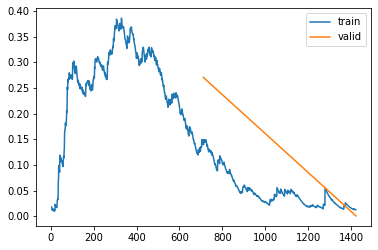

In [ ]:
learn.recorder.plot_loss()

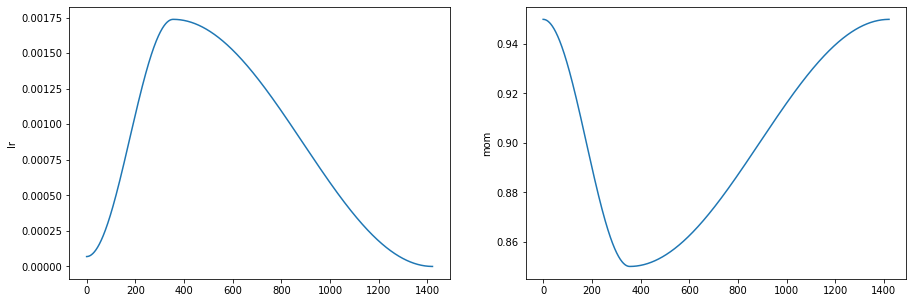

In [ ]:
learn.recorder.plot_sched(figsize=(15,5))

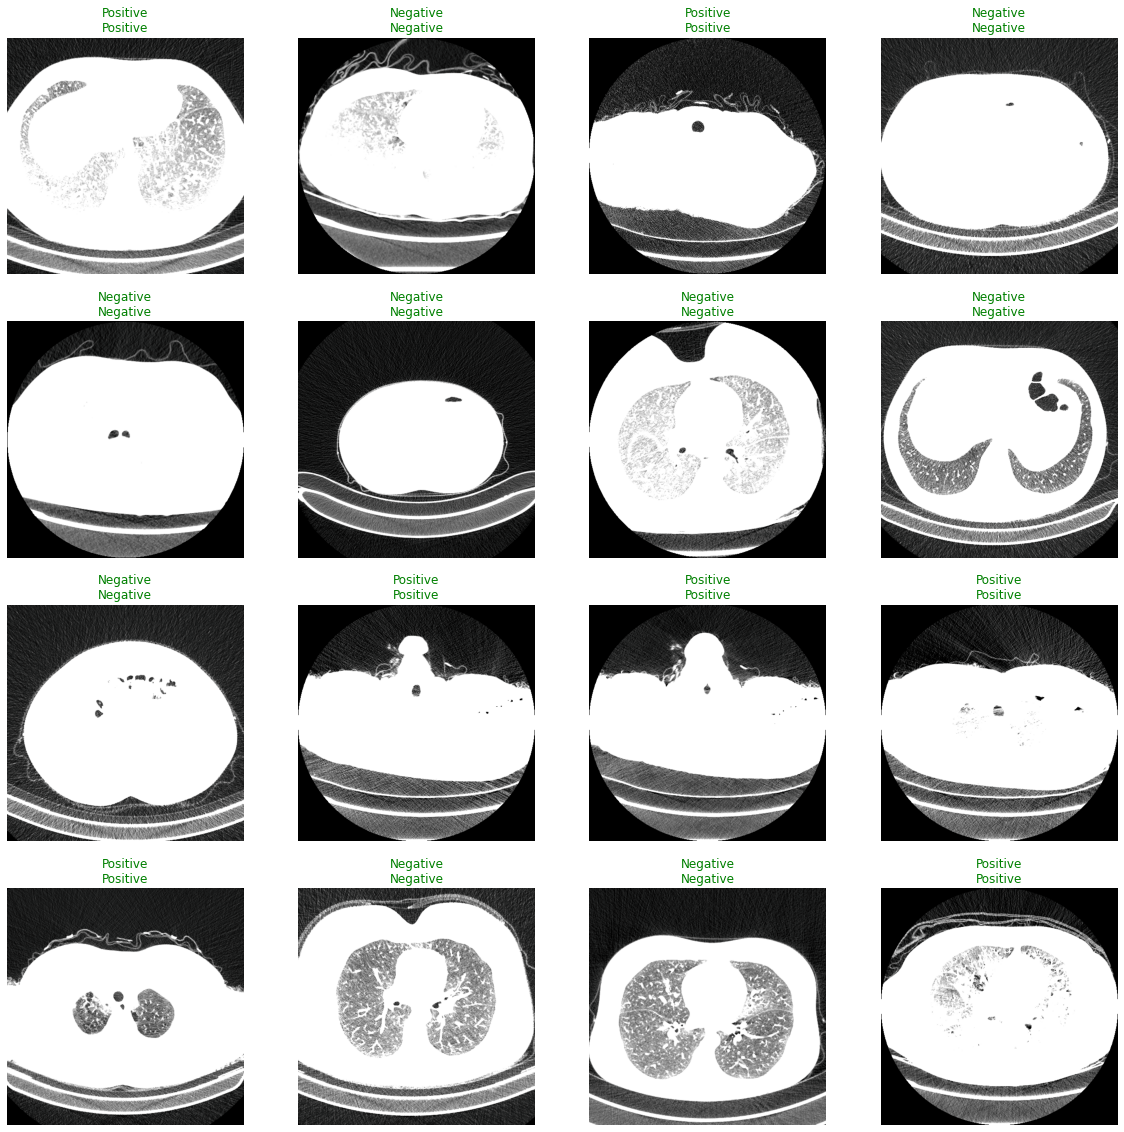

In [ ]:
learn.show_results(max_n=16,figsize=(20,20))

In [ ]:
test_path = './New Data/test-Data/test/'
test_files = get_dicom_files(test_path)
test_files

(#3406) [Path('New Data/test-Data/test/Negative/2.000000-62502-1-097.dcm'),Path('New Data/test-Data/test/Negative/2.000000-55762-1-023.dcm'),Path('New Data/test-Data/test/Negative/2.000000-57539-1-018.dcm'),Path('New Data/test-Data/test/Negative/2.000000-58080-1-182.dcm'),Path('New Data/test-Data/test/Negative/3.000000-58887-1-108.dcm'),Path('New Data/test-Data/test/Negative/3.000000-56570-1-170.dcm'),Path('New Data/test-Data/test/Negative/3.000000-56570-1-130.dcm'),Path('New Data/test-Data/test/Negative/2.000000-57539-1-162.dcm'),Path('New Data/test-Data/test/Negative/3.000000-60317-1-178.dcm'),Path('New Data/test-Data/test/Negative/3.000000-61865-1-197.dcm')...]

In [ ]:
len(test_files)

3406

In [ ]:
test_dls = dls.test_dl(test_files, bs = 16, with_labels=True) #holdout set

In [ ]:
test_interp = ClassificationInterpretation.from_learner(learn, dl=test_dls)

              precision    recall  f1-score   support

    Negative       0.51      0.40      0.45      2085
    Positive       0.29      0.39      0.33      1321

    accuracy                           0.39      3406
   macro avg       0.40      0.39      0.39      3406
weighted avg       0.42      0.39      0.40      3406



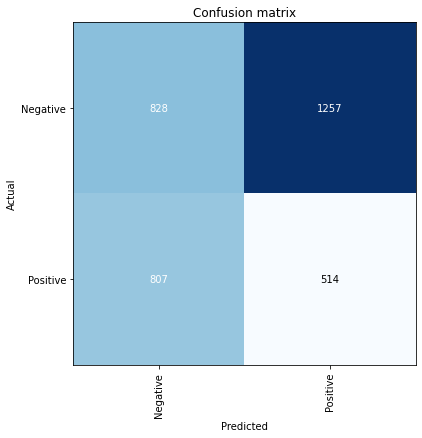

In [ ]:
test_interp.print_classification_report()
test_interp.plot_confusion_matrix(figsize=(6,6))

In [ ]:
!nvidia-smi

Fri Jan 21 00:15:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A4000           Off  | 00000000:00:05.0 Off |                  Off |
| 41%   48C    P8    17W / 140W |   2933MiB / 16117MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#import torch
#torch.cuda.empty_cache()